<a href="https://colab.research.google.com/github/SheshamJoseph/Deep-Learning-with-Tensorflow-ZTM/blob/main/04_transfer_learning_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 1: Feature Extraction

Transfer learning is a technique in machine learning in which knowledge learned from a task is re-used in order to boost performance on a related task. A common sample case is using the knowledge gained by a model that recognises cars to recognise trucks

In this Notebook we are going to cover:
* Introduction to Transfer learning with Tensorflow
* Using a small dataset to experiment faster(10% of training samples)
* Building a **Transffer learning feature extraction** model with TensorflowHub
* Use TensorBoard to track modelling experiments and results

In [2]:
# Are we using a GPU
!nvidia-smi

Sun Jan 14 11:44:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Download and become one with the data

In [3]:
# get the data(10% of 10 food classes data)
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-01-14 11:48:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c03::cf, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   247MB/s    in 0.7s    

2024-01-14 11:48:50 (247 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# walk through the folder directory
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 10 director

In [6]:
# visualizing the some of the data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pathlib
import numpy as np
# get the class names

train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)
def plot_random_images(directory, classnames=class_names ):
    plt.figure(figsize=(10, 7))
    for i in range(9):
        # Setup the target directory
        target_class = random.choice(classnames)
        target_folder = directory + target_class
        # Get a random image
        random_image = random.sample(os.listdir(target_folder), 1)
        img = mpimg.imread(target_folder+'/'+random_image[0])
        # plot image
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(target_class)
        plt.axis("off")

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


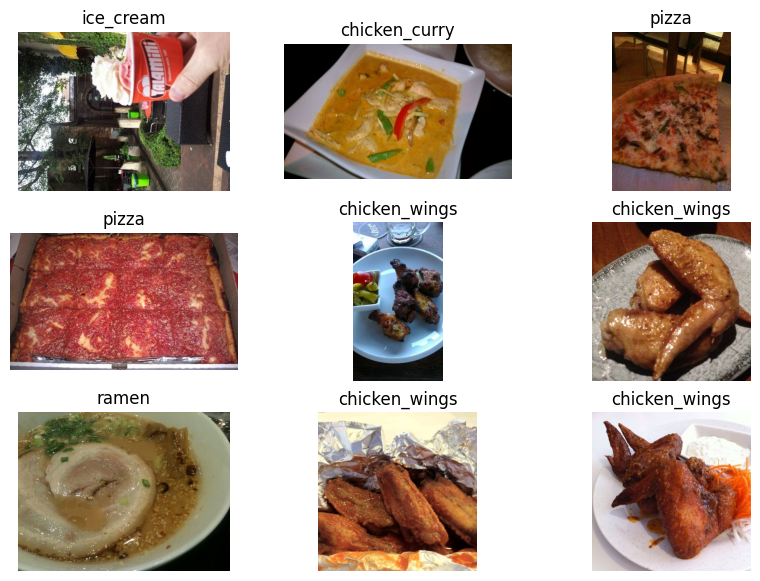

In [7]:
plot_random_images(train_dir)

## Creating data loader (preparing the data)

In [9]:
# setup data inputs
import tensorflow as tf
from tensorflow import keras

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

print("Training data")
train_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SHAPE
)

print("Testing data")
train_dataset = keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SHAPE
)

Training data
Found 750 files belonging to 10 classes.
Testing data
Found 2500 files belonging to 10 classes.


## Setting up callbacks (Things to run while our model trains)
Callbacks are extrra functionality you can add to your models to be performed during or after training.
Popular examples are:
*  Tracking experiments with the Tensorboard callback
* Model checkpoint with th ModelCheckpoint callback
* Stopping a modelfrom training before it trains too long and overfits with EarlyStopping callback